# Machine Learning Project Report

# 1. Environment & Dateset preparation

## 1.1 Import libraries

In [68]:
import numpy as np
import pandas as pd
import dotenv
import seaborn as sns
import matplotlib.pyplot as plt
from itables import show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [69]:
!kaggle datasets download -d uciml/iris
!unzip -qq -o "iris.zip" -d "dataset"
!echo "Unzip completed"

Dataset URL: https://www.kaggle.com/datasets/uciml/iris
License(s): CC0-1.0
iris.zip: Skipping, found more recently modified local copy (use --force to force download)
Unzip completed


## 1.2 Dataset Visualization

In [70]:
df = pd.read_csv('dataset/pima-indians-diabetes.csv')

In [71]:
# Display the first 5 rows of the dataset
show(df.head())

In [72]:
# Display dataset information
print(df.info())
class_names = df['Class'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Number of times pregnant                        768 non-null    int64  
 1   Plasma glucose concentration                    768 non-null    int64  
 2   Diastolic blood pressure (mm Hg)                768 non-null    int64  
 3   Triceps skin fold thickness (mm)                768 non-null    int64  
 4   2-Hour serum insulin (mu U/ml)                  768 non-null    int64  
 5   Body mass index (weight in kg/(height in m)^2)  768 non-null    float64
 6   Diabetes pedigree function                      768 non-null    float64
 7   Age (years)                                     768 non-null    int64  
 8   Class                                           768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 K

In [73]:
with pd.option_context("display.float_format", '{:,.2}'.format):
    # Basic statistics of the dataset
    print(df.describe())

       Number of times pregnant  Plasma glucose concentration  \
count                   7.7e+02                       7.7e+02   
mean                        3.8                       1.2e+02   
std                         3.4                       3.2e+01   
min                         0.0                           0.0   
25%                         1.0                       9.9e+01   
50%                         3.0                       1.2e+02   
75%                         6.0                       1.4e+02   
max                     1.7e+01                         2e+02   

       Diastolic blood pressure (mm Hg)  Triceps skin fold thickness (mm)  \
count                           7.7e+02                           7.7e+02   
mean                            6.9e+01                           2.1e+01   
std                             1.9e+01                           1.6e+01   
min                                 0.0                               0.0   
25%                          

In [74]:
# sns.pairplot(df, hue="Class")
# plt.show()

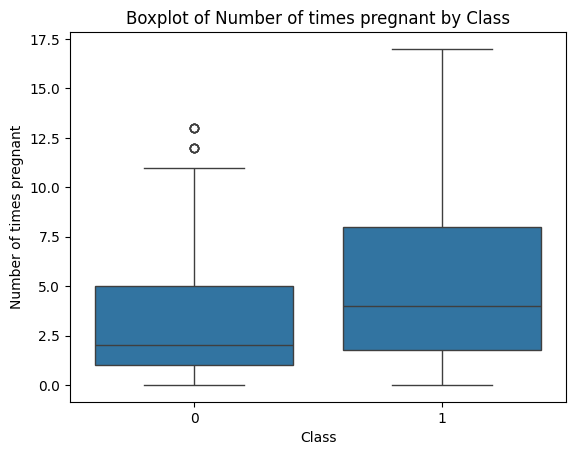

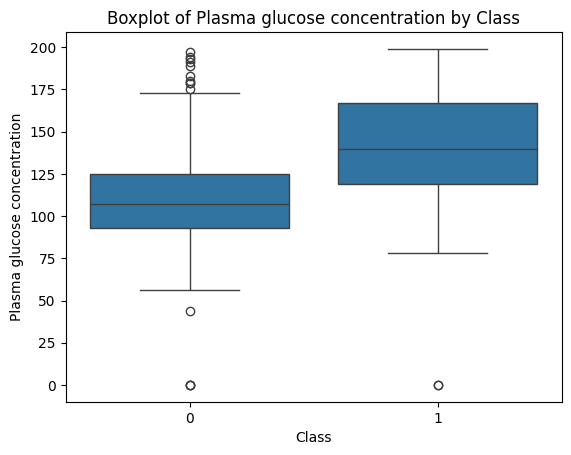

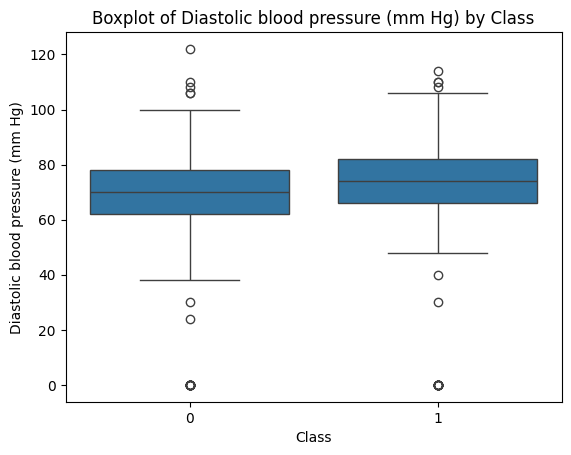

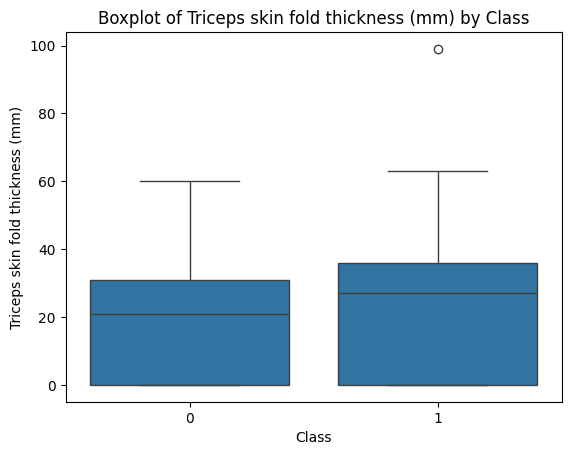

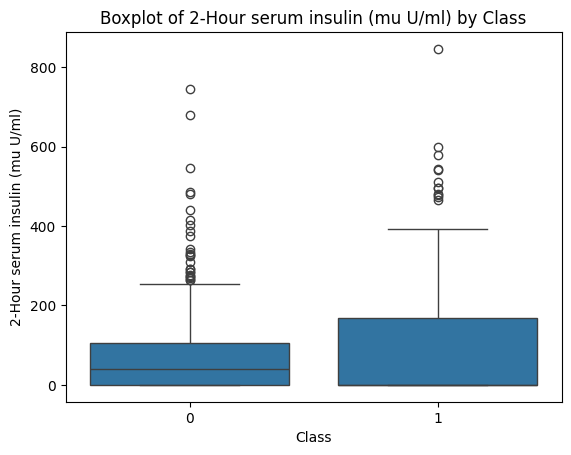

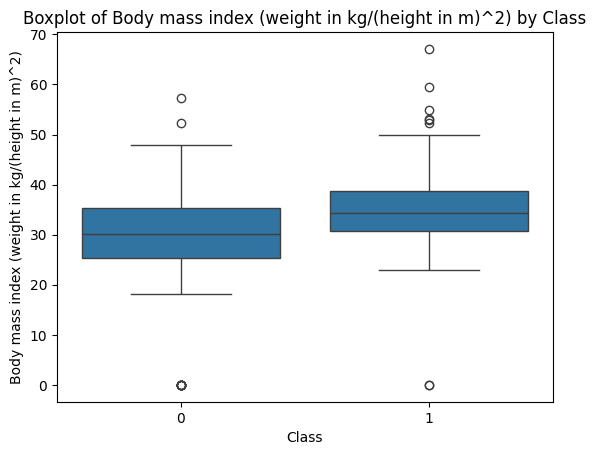

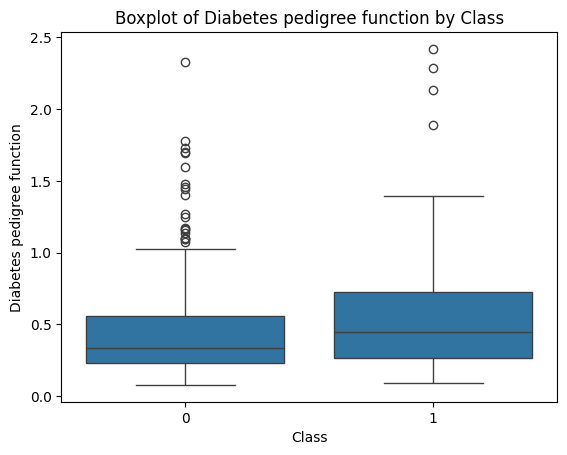

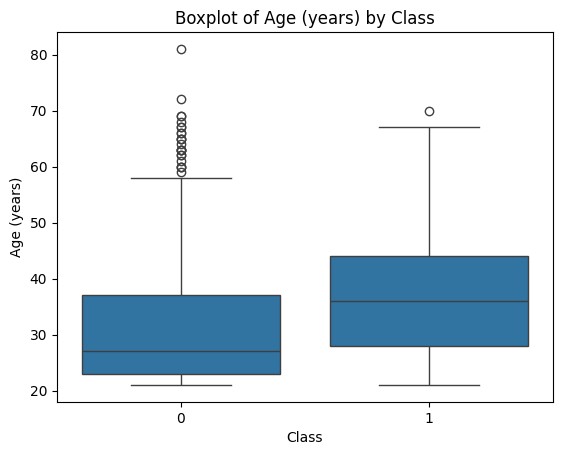

In [75]:
# Creating a boxplot for each numeric feature
features = df.columns.drop(['Class'])
for feature in features:
    sns.boxplot(x='Class', y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Class')
    plt.show()

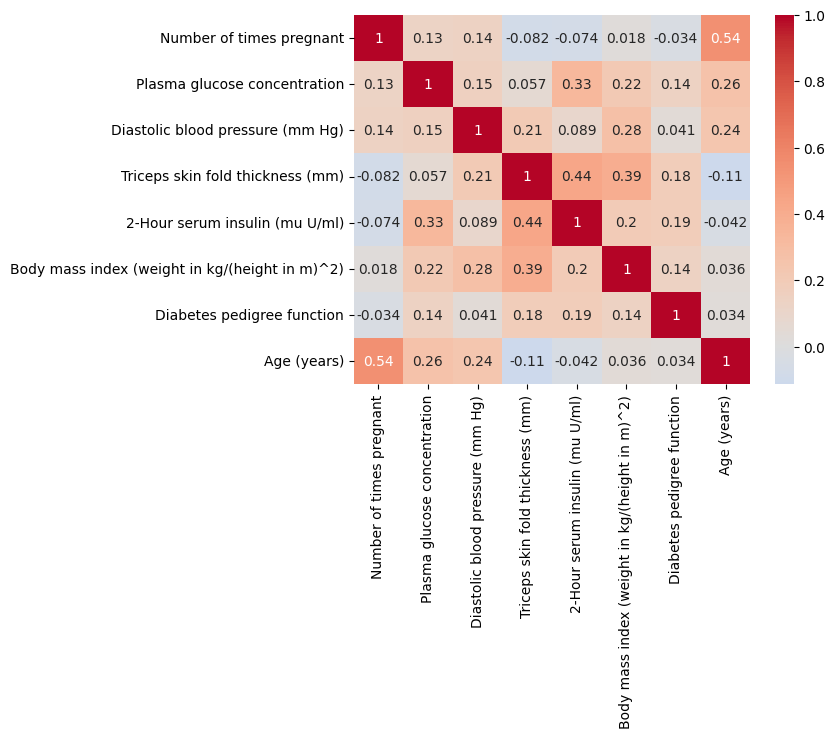

In [76]:
# Calculate correlations
corr = df[features].corr()

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.show()

## 1.3 Dataset loading and pre-processing

In [77]:
def preprocess_dataset(df, target_variable, test_size=0.2, random_state=None):
    """
    General preprocessing pipeline for a dataset to handle missing values, encoding categorical variables, 
    and scaling numerical features.

    Parameters:
    - df: Pandas DataFrame containing the dataset.
    - target_variable: The name of the column to be used as the target variable.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Controls the shuffling applied to the data before applying the split.

    Returns:
    - X_train, X_test, y_train, y_test: preprocessed split data.
    """
    
    # Separate features and target variable
    X = df.drop(columns=[target_variable])
    y = df[target_variable]
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Identifying numerical and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    # Creating transformers for numerical and categorical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combining transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Applying the ColumnTransformer to the training and testing sets
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [79]:
X_train, X_test, y_train, y_test = preprocess_dataset(df, target_variable='Class', random_state=56)

# 2. Implementation

In [80]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        # Separate the data by class
        self.classes = np.unique(y)
        self.parameters = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.parameters[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0),
                'prior': X_c.shape[0] / X.shape[0]
            }
            
    def calculate_likelihood(self, class_idx, x):
        mean = self.parameters[class_idx]["mean"]
        var = self.parameters[class_idx]["var"]
        numerator = np.exp(-(x-mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    def calculate_posterior(self, x):
        posteriors = []
        
        for c in self.classes:
            prior = np.log(self.parameters[c]["prior"])
            conditional_prob = np.sum(np.log(self.calculate_likelihood(c, x)))
            posteriors.append(prior + conditional_prob)
            
        return self.classes[np.argmax(posteriors)]
    
    def predict(self, X):
        return [self.calculate_posterior(x) for x in X]

# 3. Model Training

In [81]:
nb = GaussianNaiveBayes()
nb.fit(X_train, y_train)

# 4. Testing and evaluation


Classification report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       114
           1       0.58      0.70      0.64        40

    accuracy                           0.79       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.81      0.79      0.80       154



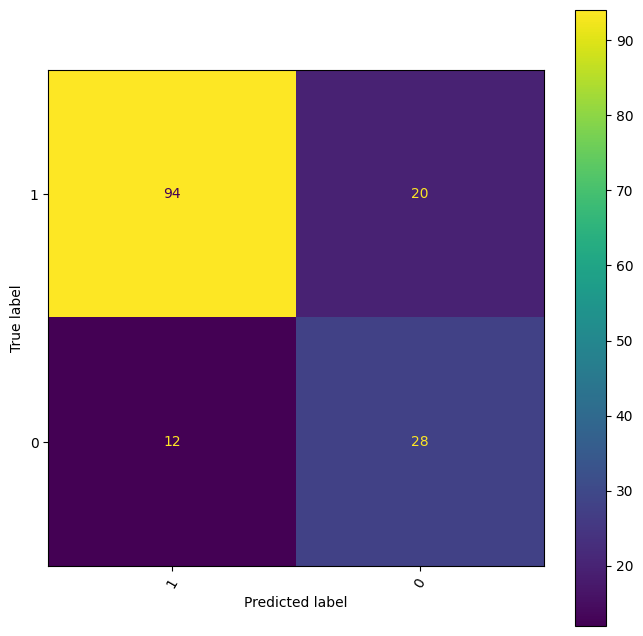

In [82]:
y_pred = nb.predict(X_test)

# Generating the classification report
class_report = classification_report(y_test, y_pred)
print('Classification report:')
print(class_report)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(xticks_rotation=60, ax=ax)
plt.show()